# Fitting a model with Markov Chain Monte Carlo

https://pysd-cookbook.readthedocs.io/en/latest/analyses/fitting/MCMC_for_fitting_models.html

In [26]:
%matplotlib inline

import pysd
import pymc as pm
import pandas as pd

from utils import globalsettings as gs

%reload_ext autoreload
%autoreload 2

In [5]:
model = pysd.read_vensim(gs.the_files.SI_MODEL)

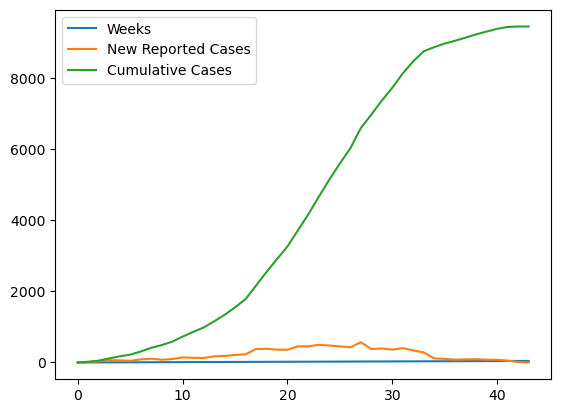

In [7]:
data = pd.read_csv(gs.the_files.EBOLA_DATA)
data.plot();

In [40]:
print(data)

    Weeks  New Reported Cases  Cumulative Cases
0     0.0                 3.0               3.0
1     1.0                16.0              19.0
2     2.0                32.0              51.0
3     3.0                64.0             115.0
4     4.0                58.0             173.0
5     5.0                48.0             221.0
6     6.0                87.0             308.0
7     7.0               105.0             413.0
8     8.0                77.0             490.0
9     9.0                96.0             586.0
10   10.0               142.0             728.0
11   11.0               132.0             860.0
12   12.0               125.0             985.0
13   13.0               172.0            1157.0
14   14.0               185.0            1342.0
15   15.0               211.0            1553.0
16   16.0               231.0            1784.0
17   17.0               380.0            2164.0
18   18.0               386.0            2550.0
19   19.0               361.0           

In [37]:

def fun_sim(population, contact_frequency):
    result = model.run(params={'total_population':population,
                               'contact_frequency':contact_frequency},
                       return_columns=['infection_rate'],
                       return_timestamps=list(data.index.values))
    return result['infection_rate'].values

In [42]:
res = fun_sim(1000, 4)

(44,)

In [48]:

mcmdl = pm.Model()

with mcmdl:
    # population = pymc.Uniform('total_population', lower=2, upper=50000, value=10000)
    population = pm.Uniform('total_population', lower=2, upper=50000, observed=10000)
    # contact_frequency = pymc.Exponential('contact_frequency', beta=5, value=5)
    contact_frequency = pm.Exponential('contact_frequency', lam=5, observed=5)

    #sim = pm.Deterministic("sim", fun_sim(population, contact_frequency))
    @pm.deterministic
    def sim(population=population, contact_frequency=contact_frequency):
        result = model.run(params={'total_population':population,
                                'contact_frequency':contact_frequency},
                        return_columns=['infection_rate'],
                        return_timestamps=list(data.index.values))
        return result['infection_rate'].values

    # admittances = pymc.Poisson('admittances', mu=sim,
    #                       value=data['New Reported Cases'], observed=Y)
    admittances = pm.Poisson('admittances', mu=sim,
                             observed=data['New Reported Cases'])

AttributeError: module 'pymc' has no attribute 'deterministic'

In [36]:
with mcmdl:
    # draw 1000 posterior samples
    idata = pm.sample(nuts_sampler="numpyro")

KeyboardInterrupt: 